# Flood-induced rice damage estimation (based on MRC, 2009)

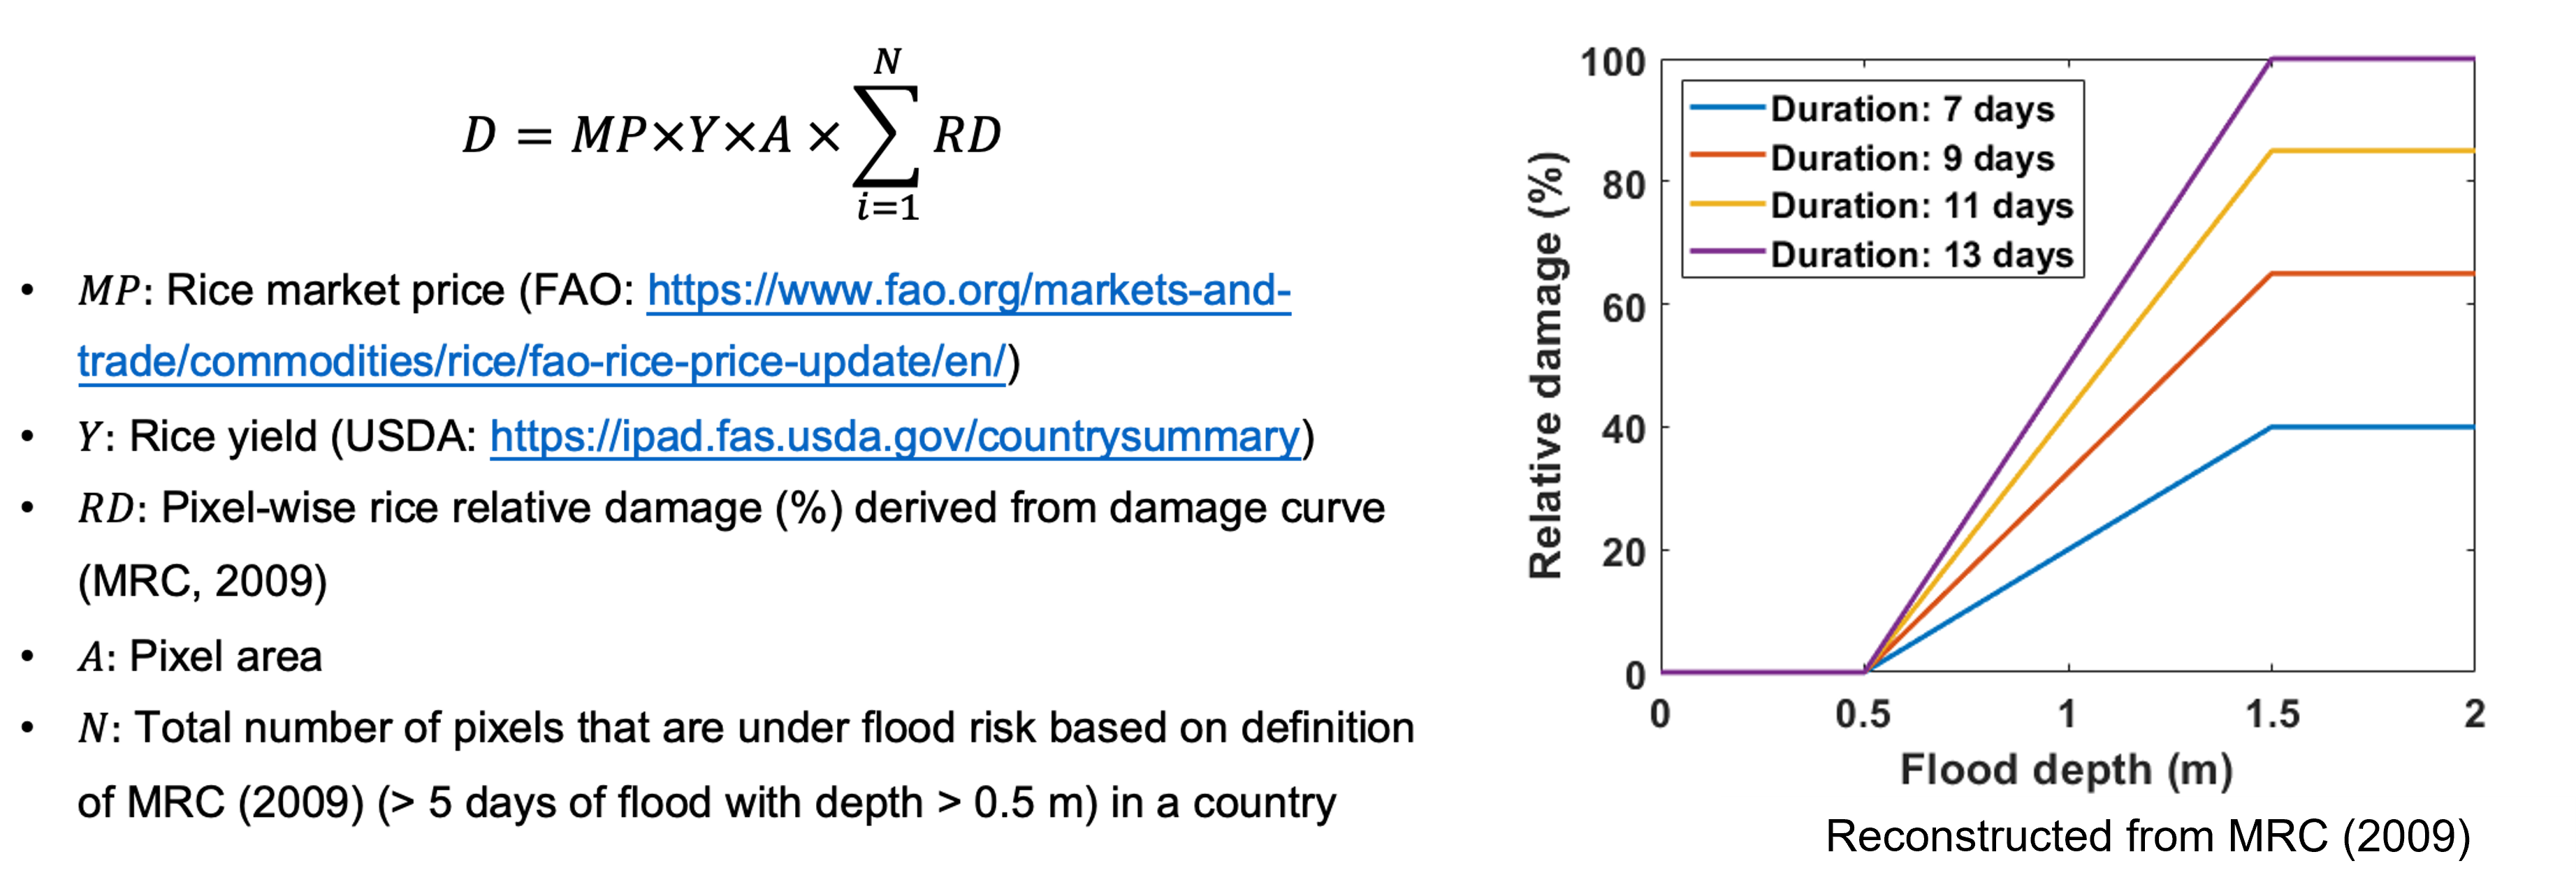

# Package installation and import

In [ ]:
!pip install \
    numpy \
    xarray \
    rioxarray \
    rasterio \
    geemap \
    folium \
    earthengine-api


In [ ]:
%pylab inline

In [ ]:
import numpy as np
import numpy.ma as ma

import xarray as xr
import rasterio
import rioxarray

import ee
import geemap
import folium

import glob

from google.colab import drive

In [ ]:
# ----- Mount your Google Drive to the Colab. This allows you to save data to your Google Drive -----
drive.mount('/content/drive')
root_output_folder = '/content/drive/MyDrive/FIER_Training_July2023' #Can be changed depending on users
try:
    os.makedirs(root_output_folder)
except:
    print('root output folder exists')

In [ ]:
ee.Authenticate()
ee.Initialize()

# Function for flood-induced rice damage estimation

In [ ]:
def flood_rice_damage(depth_stack: xr.DataArray, lulc_stack: xr.DataArray, min_risk_depth: float=0.5) -> xr.DataArray:

    """
    This function calculate the flood-induced rice economic loss (million USD) with flood depth stack,
    land-use land-cover stack, and rice-related info based on the relative damage curve.

    arg:
        depth_stack (xr.DataArray): flood depth time-series stack
        lulc_stack (xr.DataArray): Land-use land-cover stack along with country-wise rice info (market price, yield)
        min_risk_depth (float): minimum flood depth that could poses damage to rice
    """

    sqm2ha = 10**-4
    spatial_gridsize = 500 # unit: m (should be updated to read the grid size from DataArray)

    depth_stack = xr.where(depth_stack>1.5, 1.5, depth_stack)

    risky_bool_stack = depth_stack > min_risk_depth
    ct_risk_days = np.count_nonzero(risky_bool_stack, axis=0)

    rice_damage = np.zeros((risky_bool_stack.sizes['lat'], risky_bool_stack.sizes['lon']))

    for i in np.arange(risky_bool_stack.sizes['lat']):
        for j in np.arange(risky_bool_stack.sizes['lon']):
            if ct_risk_days[i,j]!=0 and ~np.isnan(lulc_stack.lulc.values[i,j]):
                risk_bool_pix = risky_bool_stack[:,i,j] # along time dimension

                group_risk_bool, group_start_index, group_length = find_runs(risk_bool_pix)

                risk_start_index = group_start_index[group_risk_bool]
                risk_length = group_length[group_risk_bool]
                risk_end_index = risk_start_index + risk_length

                max_risk_length = np.nanmax(risk_length)

                if np.nanmax(max_risk_length) <= 5:
                    continue
                elif max_risk_length>13:
                    max_risk_length = 13

                max_risk_length_index = np.argmax(risk_length)

                risk_depth_ts = depth_stack.values[risk_start_index[max_risk_length_index]:risk_end_index[max_risk_length_index],i,j]

                #print(risk_depth_ts)

                mean_risk_depth_ts = np.nanmean(risk_depth_ts)

                damage_ratio = (mean_risk_depth_ts-0.5)*(-86.875+22.5*max_risk_length-0.625*(max_risk_length**2)) # unit: %

                rice_damage[i,j] = lulc_stack.rice_market_price.values[i,j] * lulc_stack.rice_yield.values[i,j] * (spatial_gridsize**2) * sqm2ha * (damage_ratio*0.01) #* (10**-6) # unit: million USD

    rice_damage = np.where(rice_damage==0, nan, rice_damage)

    rice_damage_da = xr.DataArray(
        data=rice_damage,
        dims=["lat","lon"],
        coords={
            "lat":(["lat"], depth_stack.lat.values),
            "lon":(["lon"], depth_stack.lon.values)
        }

    )
    rice_damage_da.name = 'rice_damage'

    return rice_damage_da

def find_runs(x):
    """Find runs of consecutive items in an array."""

    # ensure array
    x = np.asanyarray(x)
    if x.ndim != 1:
        raise ValueError('only 1D array supported')
    n = x.shape[0]

    # handle empty array
    if n == 0:
        return np.array([]), np.array([]), np.array([])

    else:
        # find run starts
        loc_run_start = np.empty(n, dtype=bool)
        loc_run_start[0] = True
        np.not_equal(x[:-1], x[1:], out=loc_run_start[1:])
        run_starts = np.nonzero(loc_run_start)[0]

        # find run values
        run_values = x[loc_run_start]

        # find run lengths
        run_lengths = np.diff(np.append(run_starts, n))

        return run_values, run_starts, run_lengths



In [ ]:
# Function to visualize the result
def colorize(array, cmap='jet'):

    fig,ax = plt.subplots()
    plt.imshow(array, cmap=cmap)
    cbar = plt.colorbar(ax=ax,orientation='horizontal')
    cbar.set_label('USD', size=16, weight='bold')
    cbar.ax.tick_params(labelsize=14)
    ax.remove()
    plt.savefig(root_output_folder+'/Day02/rice_damage_cbar.png', bbox_inches='tight')
    plt.close()

    array = ma.masked_invalid(array)

    normed_data = (array - np.nanmin(array)) / (np.nanmax(array) - np.nanmin(array))
    cm = plt.colormaps.get_cmap(cmap)

    return cm(normed_data)

# Estimate flood-induced rice damage

Use the 1-18 days lead time of forecasted inundation depth maps, from 2022-10-15 to 2022-11-01, as an example.

1. Pile up forecasted flood depth maps

In [ ]:
for lead_time in np.arange(18):
    depth_fname = glob.glob(root_output_folder+"/Day02/FIER_flood_depth_maps/*lt"+str(lead_time+1).zfill(2)+"_depth.tif")[0]
    date_str = depth_fname[-25:-15]

    depth_img = rioxarray.open_rasterio(depth_fname).squeeze().drop('band').expand_dims(dim='time', axis=0).rename({"y":"lat", "x":"lon"})

    if lead_time == 0:
        depth_img_stack = depth_img
    else:
        depth_img_stack = xr.concat([depth_img_stack, depth_img], dim='time')

depth_img_stack

2. Read land cover, rice market price, and rice yield data

In [ ]:
lulc_stack = xr.load_dataset(root_output_folder+'/Day02/landcover/lulc_stack_2022.nc')
lulc_stack

3. Flood-induced rice damage estimation based on the relative damage curve (MRC, 2009)

In [ ]:
damage_da = flood_rice_damage(depth_img_stack, lulc_stack)

In [ ]:
damage_da

# Visualize the result

In [ ]:
colored_data = colorize(damage_da.values, cmap='jet')

In [ ]:
from folium.plugins import FloatImage
import base64

vis_params = {
    'min': np.nanmin(damage_da.values),
    'max': np.nanmax(damage_da.values),
    'palette': 'jet',
}
colors = vis_params['palette']
vmin = vis_params['min']
vmax = vis_params['max']


Map = folium.Map(location=(11.24,105.04), zoom_start=8)
folium.raster_layers.ImageOverlay(
    image = colored_data, #np.where(damage_da.values==0, nan, damage_da.values),
    bounds = [[damage_da.lat.values.min(), damage_da.lon.values.min()],[damage_da.lat.values.max(), damage_da.lon.values.max()]],
    name = 'Flood-induced rice damage',
).add_to(Map)
with open(root_output_folder+'/Day02/rice_damage_cbar.png', 'rb') as lf:
  # open in binary mode, read bytes, encode, decode obtained bytes as utf-8 string
  b64_content = base64.b64encode(lf.read()).decode('utf-8')
FloatImage('data:image/png;base64,{}'.format(b64_content), bottom=0, left=60, width='400px').add_to(Map)
Map
